In [1]:
import torch
import yolov5.utils
display = yolov5.utils.notebook_init()  # checks
import matplotlib.pyplot as plt
import cv2
import rospy

%matplotlib inline
# important to start the node
rospy.init_node('yolo_test_node')


YOLOv5 🚀 2024-1-24 Python-3.8.10 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7931MiB)


Setup complete ✅ (16 CPUs, 14.8 GB RAM, 193.5/245.0 GB disk)


In [2]:
import ros_numpy
import numpy as np
from sensor_msgs.msg import Image , LaserScan , PointCloud2
class RGBD():
    def __init__(self):
        
        self._cloud_sub = rospy.Subscriber(
            "/camera/depth_registered/points",
            PointCloud2, self._cloud_cb)
        self._points_data = None
        self._image_data = None
        

    def _cloud_cb(self, msg):
        self._points_data = ros_numpy.numpify(msg)
        self._image_data = self._points_data['rgb'].view((np.uint8, 4))[..., [2, 1, 0]]
        

    def get_image(self):
        return self._image_data

    def get_points(self):
        return self._points_data

In [3]:
rgbd = RGBD()


<class 'numpy.ndarray'>
(480, 640, 3)


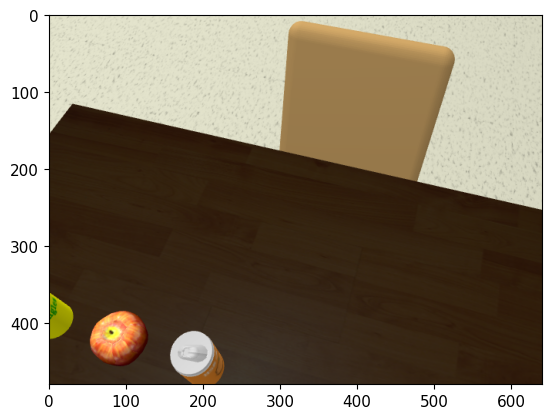

In [97]:
test_img = rgbd.get_image()
print(type(test_img))
print(test_img.shape)
plt.imshow(test_img)

(3060, 4080, 3)
0.75


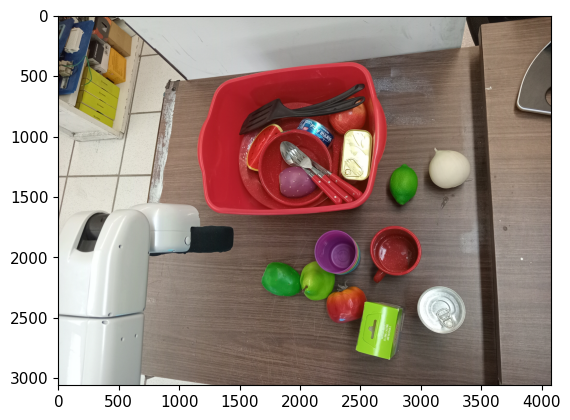

In [78]:
import rospkg
import os
import matplotlib.image as mpimg

rpg = rospkg.RosPack()
package_path = rpg.get_path('vision_modules')
img_path = os.path.join(package_path, "scripts")

img = mpimg.imread(img_path + '/20240223_171508.jpg')
img = np.asarray(img)
plt.imshow(img)
print(img.shape)
aspect_ratio = float(img.shape[0]) / float(img.shape[1])
print(aspect_ratio)


(3060, 4080, 3)
0.75
640 480
(480, 640, 3)
<class 'numpy.ndarray'>
0.75


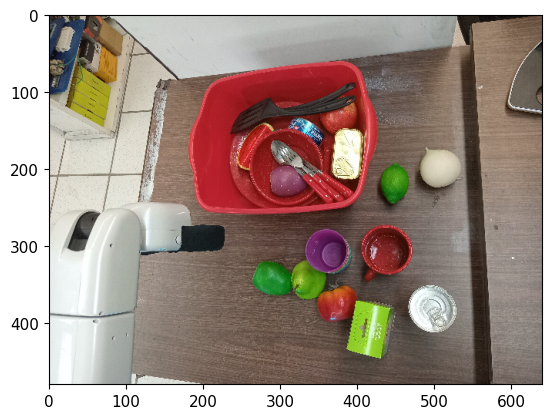

In [99]:
def resize_image(img, height=480, keep_prop=True):
    print(img.shape)
    if keep_prop:
        aspect_ratio = round(float(img.shape[0]) / float(img.shape[1]), 4)
        print(aspect_ratio)
        width = int(height/aspect_ratio)
    else:
        width = height
    
    print(width, height)
    new_img = cv2.resize(img, (width, height), interpolation=cv2.INTER_LINEAR)
    return new_img


def save_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite("simulation.png", img)


def load_image():
    test_img = cv2.imread(img_path + '/simulation.png')
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    return test_img


#test_img = cv2.imread(img_path + '/simulation.png')
#test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

test_img = resize_image(img, 480, True)
print(test_img.shape)
print(type(test_img))
plt.imshow(test_img)
aspect_ratio = float(test_img.shape[0]) / float(test_img.shape[1])
print(aspect_ratio)

#save_image(test_img)

In [8]:
from yolov5.models.experimental import attempt_load
from yolov5.utils.general import *
from yolov5.utils.torch_utils import select_device

from cv_bridge import CvBridge
from object_classification.srv import Classify,ClassifyResponse, ClassifyRequest
import torch

device = select_device('')
file_path = rpg.get_path('object_classification')
ycb_yolo_path=file_path+'/src/weights/ycb.pt'
print(ycb_yolo_path)
model=attempt_load(ycb_yolo_path,device)

YOLOv5 🚀 2024-1-24 Python-3.8.10 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7931MiB)



/home/devan/GIT/Juskeshino/catkin_ws/src/vision/object_classification/src/weights/ycb.pt


Fusing layers... 
Model summary: 369 layers, 21138024 parameters, 0 gradients, 49.1 GFLOPs


(480, 640, 3)
torch.Size([1, 3, 480, 640])
<class 'numpy.ndarray'>
[tensor([[ 4.66839e+02,  3.51200e+02,  5.29462e+02,  4.12321e+02,  9.67776e-01,  3.40000e+01],
        [ 3.14382e+02,  3.19958e+02,  3.58924e+02,  3.69632e+02,  9.26690e-01,  5.40000e+01],
        [ 2.86949e+02,  1.97535e+02,  3.34016e+02,  2.37618e+02,  9.21282e-01,  2.30000e+01],
        [ 4.29769e+02,  1.93429e+02,  4.66925e+02,  2.45520e+02,  9.14489e-01,  1.50000e+01],
        [ 4.05502e+02,  2.72922e+02,  4.71568e+02,  3.37311e+02,  8.43801e-01,  2.00000e+01],
        [ 4.82166e+02,  1.71811e+02,  5.35544e+02,  2.24355e+02,  8.15811e-01,  3.60000e+01],
        [ 8.49594e-01,  2.51798e+02,  1.18923e+02,  4.74510e+02,  8.15710e-01,  1.80000e+01],
        [ 5.43552e+01,  5.67566e-01,  9.99334e+01,  5.47305e+01,  7.69011e-01,  5.80000e+01],
        [ 4.05464e-02,  1.03628e+02,  8.41206e+01,  1.64096e+02,  7.58689e-01,  5.80000e+01],
        [ 1.09684e+02,  4.68010e+02,  2.08863e+02,  4.80125e+02,  7.57501e-01,  2.1000

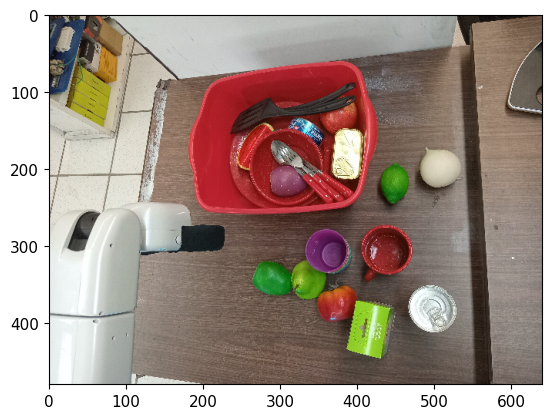

In [106]:
sampling_img = test_img
print(sampling_img.shape)
sample = torch.from_numpy(sampling_img).to(device)
sample = sample / 255.0
sample = sample.unsqueeze(0)
sample = torch.moveaxis(sample, 3, 1)
print(sample.shape)
pred = model(sample, augment=False)[0]

plt.imshow(sampling_img)
print(type(sampling_img))

detections = non_max_suppression(pred)  # IOU 
print(detections)
print(detections[0].shape)

#(480, 640, 3)
#torch.Size([1, 3, 480, 640])

In [113]:
def calc_IOU(boxA, boxB):
	xA = max(boxA[0][0], boxB[0][0])
	yA = max(boxA[0][1], boxB[0][1])
	xB = min(boxA[1][0], boxB[1][0])
	yB = min(boxA[1][1], boxB[1][1])
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	boxAArea = (boxA[1][0] - boxA[0][0] + 1) * (boxA[1][1] - boxA[0][1] + 1)
	boxBArea = (boxB[1][0] - boxB[0][0] + 1) * (boxB[1][1] - boxB[0][1] + 1)
	iou = interArea / float(boxAArea + boxBArea - interArea)
	return iou


def plot_labels(points, labels, sampling_img):
    debug_img = sampling_img.copy()
    for (point, label) in zip(points, labels):
        print(label)
        debug_img = cv2.rectangle(debug_img, point[0] , point[1],  (0, 255, 0), 1)
        debug_img = cv2.putText(debug_img, label[1], (point[0][0]-10, point[0][1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        print(point[0], point[1], label[0], label[1])
        print()
    #plt.imshow(debug_img)
    return debug_img


def get_notations(detections, confidence_threshold = 0.4, rem_overlaps=False):
    points = []
    labels = []
    for detect in detections:
        for *xyxy, conf, cls in (detect):# Model Result is bounding box  confidence  and class
            if conf.cpu().tolist() > confidence_threshold:
                pt_min = (int(xyxy[0].cpu().tolist()), int(xyxy[1].cpu().tolist()))
                pt_max = (int(xyxy[2].cpu().tolist()), int(xyxy[3].cpu().tolist()))

                points.append((pt_min, pt_max))
                labels.append([round(conf.cpu().tolist(), 3), model.names[int(cls.cpu().tolist())]])     

    print(labels)
    print(points)
    if rem_overlaps:
        for i, (point, label) in enumerate(zip(points, labels)):
            for j, (p, l) in enumerate(zip(points, labels)):
                if i != j:
                    iou = calc_IOU(point, p)
                    if iou > 0.9:
                        points.pop(j)
                        labels.pop(j)
    
    print(labels)
    print(points)
    return points, labels
 

[[0.968, '053-a_mini_soccer_ball'], [0.927, '065-i_cups'], [0.921, '024_bowl'], [0.914, '016_pear'], [0.844, '020_pitcher_lid'], [0.816, '054_softball'], [0.816, '019-a_pitcher_base'], [0.769, '071_nine_hole_peg_test'], [0.759, '071_nine_hole_peg_test'], [0.758, '021_bleach_cleanser'], [0.754, '020_pitcher_lid'], [0.741, '029_plate'], [0.729, '024_bowl'], [0.726, '012_strawberry'], [0.689, '059_chain'], [0.679, '024_bowl'], [0.674, '062_dice'], [0.673, '019-a_pitcher_base'], [0.609, '029_plate'], [0.607, '029_plate'], [0.607, '024_bowl'], [0.582, '011_banana'], [0.553, '010_potted_meat_can'], [0.534, '065-i_cups'], [0.532, '071_nine_hole_peg_test'], [0.518, '062_dice'], [0.491, '010_potted_meat_can'], [0.465, '025_mug'], [0.464, '077_rubiks_cube'], [0.455, '029_plate'], [0.452, '002_master_chef_can'], [0.446, '065-f_cups'], [0.446, '006_mustard_bottle']]
[((466, 351), (529, 412)), ((314, 319), (358, 369)), ((286, 197), (334, 237)), ((429, 193), (466, 245)), ((405, 272), (471, 337)), ((

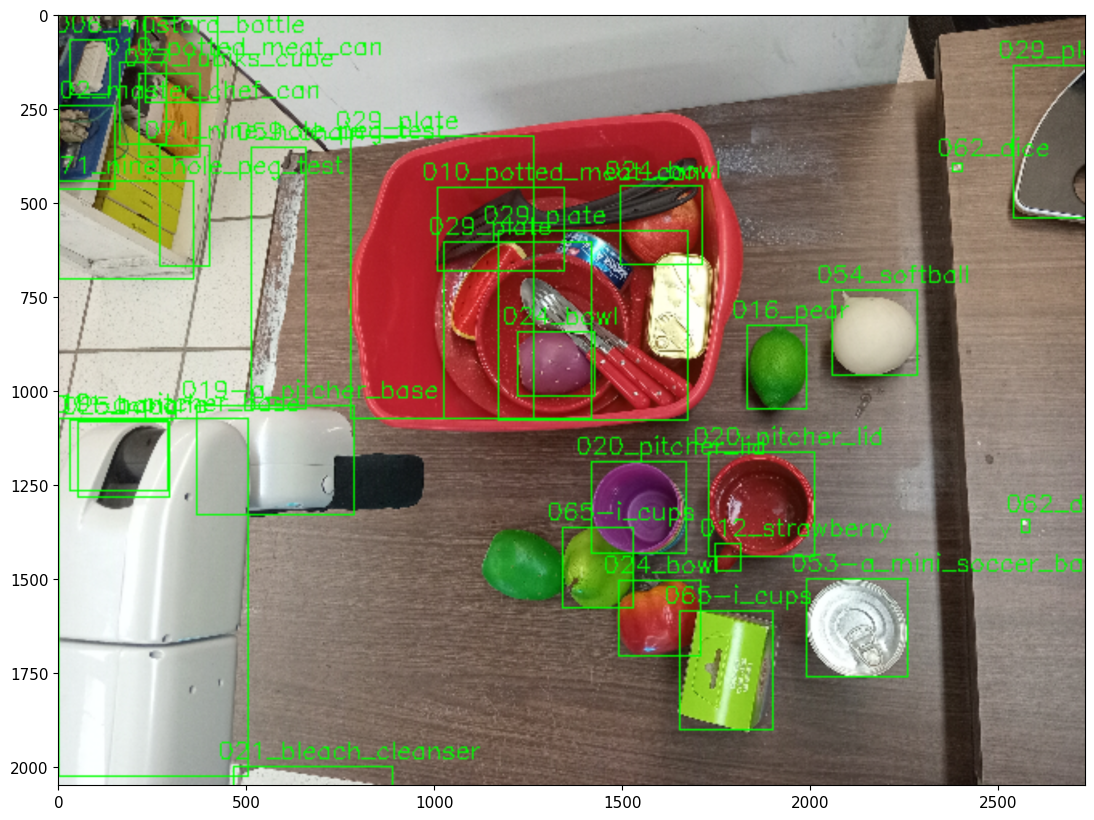

In [115]:
points, labels = get_notations(detections, rem_overlaps=True)
print()
labeled_image = plot_labels(points, labels, sampling_img)

labeled_image = resize_image(labeled_image, 2048)
plt.figure(figsize=(14,10))
plt.imshow(labeled_image)


# ----------------------------

In [ ]:
debug_img = sampling_img.copy()

num_preds = 0
points = []
confidence_threshold = 0.4

for detect in detections:
    for *xyxy, conf, cls in (detect):# Model Result is bounding box  confidence  and class
        if conf.cpu().tolist() > confidence_threshold:
            num_preds+=1
            pt_min = (int(xyxy[0].cpu().tolist()), int(xyxy[1].cpu().tolist()))
            pt_max = (int(xyxy[2].cpu().tolist()), int(xyxy[3].cpu().tolist()))

            points.append((pt_min, pt_max))

            debug_img = cv2.rectangle(debug_img ,pt_min,pt_max,  (0, 255, 0), 2)
            debug_img = cv2.putText(debug_img, model.names[int(cls.cpu().tolist())],
                        pt_min, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            print(num_preds, pt_min, pt_max, conf.cpu().tolist(), model.names[int(cls.cpu().tolist())] )
    
plt.imshow(debug_img)